# Aula 6 - Segmentação

In [45]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Ler a base
df = pd.read_csv('../bases/clientes.csv')
print("[INFO] Dimensões:", df.shape)
print("[INFO] Colunas:", list(df.columns))
print(df.info())
print("#"*120)
print("")
print(df.describe())

[INFO] Dimensões: (500, 10)
[INFO] Colunas: ['Idade', 'Gênero', 'EstadoCivil', 'Escolaridade', 'RendaMensal', 'TempoNoSite(min)', 'VisitasMensais', 'ValorMedioCompra', 'CategoriaFavorita', 'Dispositivo']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Idade              500 non-null    int64  
 1   Gênero             500 non-null    object 
 2   EstadoCivil        500 non-null    object 
 3   Escolaridade       500 non-null    object 
 4   RendaMensal        500 non-null    object 
 5   TempoNoSite(min)   500 non-null    float64
 6   VisitasMensais     500 non-null    int64  
 7   ValorMedioCompra   500 non-null    int64  
 8   CategoriaFavorita  500 non-null    object 
 9   Dispositivo        500 non-null    object 
dtypes: float64(1), int64(3), object(6)
memory usage: 39.2+ KB
None
###############################################

In [46]:
df

,Idade,Gênero,EstadoCivil,Escolaridade,RendaMensal,TempoNoSite(min),VisitasMensais,ValorMedioCompra,CategoriaFavorita,Dispositivo
0,56,Feminino,Casado,Pós-graduação,5 a 10 mil,8.68,5,100,Alimentos,Mobile
1,69,Feminino,Divorciado,Médio,2 a 5 mil,15.51,4,200,Eletrônicos,Mobile
2,46,Feminino,Solteiro,Médio,Até 2 mil,8.61,5,1000,Eletrônicos,Tablet
3,32,Feminino,Solteiro,Superior,Acima de 20 mil,0.01,8,200,Casa,Desktop
4,60,Masculino,Casado,Superior,5 a 10 mil,5.06,4,300,Alimentos,Mobile
...,...,...,...,...,...,...,...,...,...,...
495,65,Masculino,Solteiro,Médio,2 a 5 mil,2.21,4,100,Livros,Mobile
496,42,Feminino,Solteiro,Médio,10 a 20 mil,13.03,7,50,Moda,Desktop
497,57,Masculino,Solteiro,Fundamental,5 a 10 mil,1.30,1,50,Esportes,Desktop
498,62,Masculino,Divorciado,Superior,5 a 10 mil,5.03,7,1000,Eletrônicos,Desktop



## Padrão básico da API do scikit-learn

- fit(X, y=None): ajusta o estimador aos dados (aprende parâmetros).
- transform(X): transforma X com base no que foi aprendido no fit.
- fit_transform(X): faz fit + transform de uma vez (muito comum em pré-processamento).
- predict(X): gera previsões/labels após o modelo estar ajustado.
- fit_predict(X): ajusta e já retorna os rótulos (muito usado em clustering).

#### Exemplo ilustrativo (NÃO executado aqui):
```python
scaler = StandardScaler()               # o algoritmo
X_scaled = scaler.fit_transform(X)      # ajusta e transforma
pca = PCA(n_components=2)               # o algoritmo
X_pca = pca.fit_transform(X_scaled)     # ajusta e projeta
km = KMeans(n_clusters=4, n_init=10, random_state=42) # o algoritmo
labels = km.fit_predict(X_pca)          # ajusta e retorna rótulos
```

## Pré-processamento

Para fazermos a segmentação, é importante fazermos o pré-processamento dos dados. Um dos principais pré-processamentos é a padronização, que nada mais é que colocar todos os dados em uma mesma **escala**. Contudo, só deve ser feito em variáveis **numéricas**. Vamos separar os dois casos (numéricos e categóricos) com o método `select_dtypes()`.

In [9]:
numericas = df.select_dtypes(include='number').columns.tolist()    # Aqui, incluimos apenas os números
categoricas = df.select_dtypes(exclude='number').columns.tolist()  # Aqui, excluimos os números, mantendo apenas as categóricas.

print(f'[INFO] Numéricas: {numericas}')
print(f'[INFO] Categóricas: {categoricas}')

[INFO] Numéricas: ['Idade', 'TempoNoSite(min)', 'VisitasMensais', 'ValorMedioCompra']
[INFO] Categóricas: ['Gênero', 'EstadoCivil', 'Escolaridade', 'RendaMensal', 'CategoriaFavorita', 'Dispositivo']


### Padronização

In [12]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[numericas])  # Atenção: aqui fizemos só com as numéricas e aplicamos o fit_transform!

print("Antes:")
print(df[numericas].head())
print("#"*120)
print("Depois:")
print(pd.DataFrame(df_scaled[:5], columns=numericas))

Antes:
   Idade  TempoNoSite(min)  VisitasMensais  ValorMedioCompra
0     56              8.68               5               100
1     69             15.51               4               200
2     46              8.61               5              1000
3     32              0.01               8               200
4     60              5.06               4               300
########################################################################################################################
Depois:
      Idade  TempoNoSite(min)  VisitasMensais  ValorMedioCompra
0  0.784233          0.741806       -0.003626         -0.578486
1  1.649686          2.112274       -0.456865         -0.122626
2  0.118500          0.727760       -0.003626          3.524249
3 -0.813526         -0.997865        1.356092         -0.122626
4  1.050527          0.015438       -0.456865          0.333233


### OneHotEncoder

Quando temos variáveis categórias, não existe padronização possível. O processamento que fazemos, em geral, é transformar todas as variáveis em *OnehotEncoding*, ou seja, se temos uma coluna de Gênero com as respostas Masculino e Feminino, o OneHotEncoding transforma em duas colunas, Masculino e Feminino, onde os valores são 0 ou 1. Isso facilita o trabalho dos algoritmos e torna nossos modelos melhores.

In [13]:
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
df_ohe = ohe.fit_transform(df[categoricas])
print("Antes:")
print(df[categoricas].head())
print("Depois:")
pd.DataFrame(df_ohe, columns=ohe.get_feature_names_out()).head()

Antes:
      Gênero EstadoCivil   Escolaridade      RendaMensal CategoriaFavorita  \
0   Feminino      Casado  Pós-graduação       5 a 10 mil         Alimentos   
1   Feminino  Divorciado          Médio        2 a 5 mil       Eletrônicos   
2   Feminino    Solteiro          Médio        Até 2 mil       Eletrônicos   
3   Feminino    Solteiro       Superior  Acima de 20 mil              Casa   
4  Masculino      Casado       Superior       5 a 10 mil         Alimentos   

  Dispositivo  
0      Mobile  
1      Mobile  
2      Tablet  
3     Desktop  
4      Mobile  
Depois:


,Gênero_Feminino,Gênero_Masculino,Gênero_Outro,EstadoCivil_Casado,EstadoCivil_Divorciado,EstadoCivil_Solteiro,EstadoCivil_Viúvo,Escolaridade_Fundamental,Escolaridade_Médio,Escolaridade_Pós-graduação,...,RendaMensal_Até 2 mil,CategoriaFavorita_Alimentos,CategoriaFavorita_Casa,CategoriaFavorita_Eletrônicos,CategoriaFavorita_Esportes,CategoriaFavorita_Livros,CategoriaFavorita_Moda,Dispositivo_Desktop,Dispositivo_Mobile,Dispositivo_Tablet
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## Juntando tudo

Agora precisamos concatenar as duas tabelas. Para isso, usamos a função `hstack`(horizontal stack, empilhando horizontal) do numpy. Percebam como as bases deixam de ser dataframes e viram vetores/matrizes.

In [14]:
X_processed = np.hstack((df_scaled, df_ohe))
print(X_processed)

[[ 0.78423339  0.74180622 -0.00362591 ...  0.          1.
   0.        ]
 [ 1.6496862   2.11227381 -0.45686522 ...  0.          1.
   0.        ]
 [ 0.11850046  0.72776043 -0.00362591 ...  0.          0.
   1.        ]
 ...
 [ 0.85080668 -0.73902114 -1.81658316 ...  1.          0.
   0.        ]
 [ 1.18367315  0.0094187   0.90285271 ...  1.          0.
   0.        ]
 [-1.74555174 -0.7470473  -0.91010454 ...  0.          1.
   0.        ]]


## PCA - Redução de Dimensionalidade

O PCA é uma técnica estatística utilizada para reduzir a dimensionalidade dos dados sem perder as informações mais relevantes. Quando lidamos com muitas variáveis ao mesmo tempo (como idade, renda, tempo de navegação, frequência de compra etc.), é comum que algumas delas estejam correlacionadas e contenham informações repetidas. O PCA busca **identificar novas variáveis** — chamadas de componentes principais — que são **combinações lineares** das variáveis originais. Esses componentes são construídos de forma a capturar a maior quantidade possível da variância dos dados. **Na prática, isso significa que podemos resumir um conjunto complexo de variáveis em poucas dimensões**, mantendo a essência das diferenças entre os indivíduos. Por exemplo, em vez de analisar 10 variáveis separadamente, é possível projetar os dados em 2 ou 3 componentes principais e ainda assim visualizar padrões, relações e agrupamentos de forma clara e simplificada.

In [37]:
pca = PCA(n_components=2, random_state=93)      # Aqui devemos definir para quantas dimensões queremos reduzir
X_pca = pca.fit_transform(X_processed)
print("[INFO] PCA -> número de componentes:", pca.n_components)
print("[INFO] Variância explicada (% por componente):", (pca.explained_variance_ratio_ * 100).round(3))
print("[INFO] Variância explicada acumulada (%):", round(pca.explained_variance_ratio_.sum() * 100, 3))

[INFO] PCA -> número de componentes: 2
[INFO] Variância explicada (% por componente): [14.074 12.79 ]
[INFO] Variância explicada acumulada (%): 26.864


In [38]:
X_pca[:5]

array([[-0.297612  ,  0.26106676],
       [ 0.43000701,  0.49323561],
       [ 2.34182967,  1.01697315],
       [-0.27243463,  0.84827506],
       [-0.47516946, -0.00579696]])

## K-Means

O K-Means é um dos algoritmos mais conhecidos para agrupamento não supervisionado. Seu objetivo é **dividir um conjunto de observações em k grupos (clusters) de modo que os elementos dentro de um mesmo grupo sejam mais parecidos entre si do que em relação aos elementos de outros grupos** (lembrando muito o kNN). O processo funciona de forma iterativa: primeiro, escolhem-se aleatoriamente k pontos iniciais (centroides). Em seguida, cada observação é atribuída ao centroide mais próximo, formando grupos temporários. Os centroides são então recalculados com base na média das observações em cada grupo, e o processo se repete até que não haja mais mudanças significativas. O resultado final é uma partição dos dados que revela padrões de similaridade latentes. Essa técnica é especialmente útil em marketing.

Mas como escolher o número ideal de grupos? Existe uma métrica chamada **Silhouette Score**. O Silhouette Score é uma métrica que avalia a qualidade de um agrupamento. Quando usamos algoritmos como o K-Means, precisamos decidir o número de grupos (k) mais adequado. O Silhouette ajuda justamente nessa escolha, medindo o quão bem cada ponto está posicionado em relação ao seu próprio cluster e aos demais. O cálculo considera dois fatores: (1) a cohesão, ou seja, o quão próximo um ponto está dos elementos do seu próprio grupo; e (2) a separação, isto é, o quão distante ele está dos elementos de outros grupos.

O resultado é um valor que varia entre -1 e 1. Valores próximos de 1 indicam que os pontos estão bem agrupados dentro de seus clusters e distantes dos demais (ou seja, os grupos estão bem definidos). Valores próximos de 0 sugerem sobreposição entre clusters, indicando que a separação não é clara. Já valores negativos indicam que muitos pontos podem ter sido atribuídos ao grupo “errado”. Na prática, o Silhouette Score permite comparar diferentes segmentações (por exemplo, k=2, k=3, k=4) e escolher aquela que apresenta a melhor combinação entre coesão interna e separação externa, garantindo uma segmentação mais robusta e interpretável.

Executaremos, com um `for`, vários k's possíveis, guardaremos o valor e aí veremos qual o maior, para então utilizá-lo definitivamente.

In [39]:
scores = {}
for k in range(2, 21): # Vou fazer até 20 K (21 - 1)
  km_tmp = KMeans(n_clusters=k, n_init=10, random_state=42)
  labels_tmp = km_tmp.fit_predict(X_pca)
  score_tmp = silhouette_score(X_pca, labels_tmp)
  scores[k] = score_tmp

print("[INFO] Silhouette por K (2..20):")
for k, score in scores.items():
  print(f"K={k}: {score:.4f}")

[INFO] Silhouette por K (2..20):
K=2: 0.3793
K=3: 0.3755
K=4: 0.3231
K=5: 0.3514
K=6: 0.3732
K=7: 0.3472
K=8: 0.3506
K=9: 0.3541
K=10: 0.3537
K=11: 0.3524
K=12: 0.3461
K=13: 0.3404
K=14: 0.3487
K=15: 0.3483
K=16: 0.3439
K=17: 0.3441
K=18: 0.3476
K=19: 0.3378
K=20: 0.3506


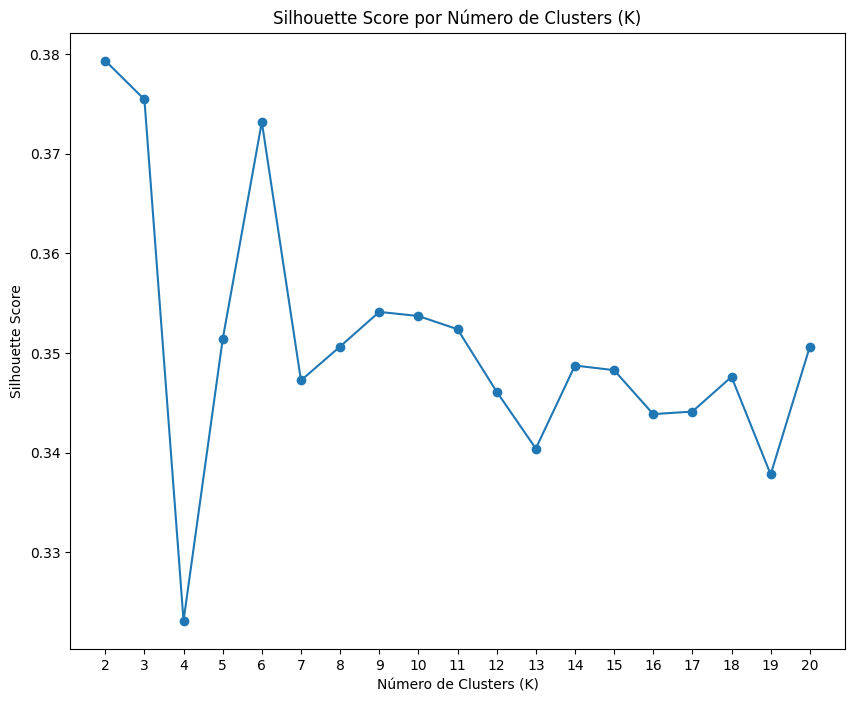

In [40]:
# Plota o silhouette score
plt.figure(figsize=(10, 8))
plt.plot(list(scores.keys()), list(scores.values()), marker='o')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Silhouette Score')
plt.xticks(list(scores.keys()))
plt.title('Silhouette Score por Número de Clusters (K)')
plt.show()

In [41]:
best_k = max(scores, key=scores.get) + 4 # O melhor, nos dados fakes, foi o 2, mas eu quis colocar o 6 para termos variabilidade, por isso somei 4.k
print("[INFO] Melhor K:", best_k)

[INFO] Melhor K: 6


Agora rodamos com o `best_k`

In [42]:
kmeans = KMeans(n_clusters=best_k, n_init=10, random_state=42)
labels = kmeans.fit_predict(X_pca)
df_clusters = df.copy()
df_clusters['Cluster'] = labels
print("[INFO] Tabela com rótulos:")
df_clusters.head()

[INFO] Tabela com rótulos:


,Idade,Gênero,EstadoCivil,Escolaridade,RendaMensal,TempoNoSite(min),VisitasMensais,ValorMedioCompra,CategoriaFavorita,Dispositivo,Cluster
0,56,Feminino,Casado,Pós-graduação,5 a 10 mil,8.68,5,100,Alimentos,Mobile,4
1,69,Feminino,Divorciado,Médio,2 a 5 mil,15.51,4,200,Eletrônicos,Mobile,4
2,46,Feminino,Solteiro,Médio,Até 2 mil,8.61,5,1000,Eletrônicos,Tablet,1
3,32,Feminino,Solteiro,Superior,Acima de 20 mil,0.01,8,200,Casa,Desktop,4
4,60,Masculino,Casado,Superior,5 a 10 mil,5.06,4,300,Alimentos,Mobile,2


### Entendendo cada cluster

Para entender cada segmento/cluster, podemos extrair métricas de cada um deles. Para as variáveis numéricas, podemos extrair média/mediana. Para as categóricas, podemos entender a % de cada categoria interna.

In [43]:
print("\n[Médias numéricas por cluster]")
print(df_clusters.groupby("Cluster")[numericas].mean().round(2)) # Aqui tiramos a média e usamos .round(2) para arredondar a 2 casas decimais.

for c in categoricas:
  print(f"\n[Distribuição de '{c}' por cluster' (%)]")
  dist = (
      df_clusters.groupby("Cluster")[c]
      .value_counts(normalize=True) # Tiramos a proporção de cada
      .rename("pct")                # Renomeamos pra pct
      .mul(100)                     # Multiplicamos por 100
      .round(1)                     # arredondamos pra 1 casa decimal
      .unstack(fill_value=0)        # Fazemos um pivot (deitamos a tabela)
  )
  print(dist)
  print() # só pra pular linha


[Médias numéricas por cluster]
         Idade  TempoNoSite(min)  VisitasMensais  ValorMedioCompra
Cluster                                                           
0        37.41              3.31            2.88            147.15
1        38.29             12.72            6.40            580.95
2        56.92              2.25            4.73            131.19
3        27.81             10.01            3.67            365.48
4        41.69              5.78            5.55            226.27
5        54.68              3.07            8.42            221.21

[Distribuição de 'Gênero' por cluster' (%)]
Gênero   Feminino  Masculino  Outro
Cluster                            
0            44.7       54.5    0.8
1            52.4       40.5    7.1
2            45.9       48.6    5.5
3            26.2       61.9   11.9
4            50.0       45.8    4.2
5            62.1       34.8    3.0


[Distribuição de 'EstadoCivil' por cluster' (%)]
EstadoCivil  Casado  Divorciado  Solteiro  Viúvo

## Visualizando os clusters

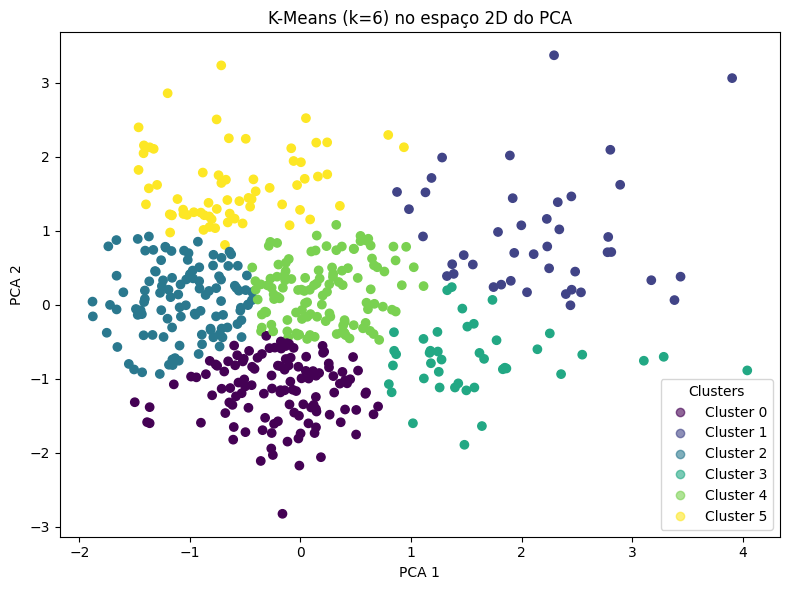

In [44]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title(f"K-Means (k={best_k}) no espaço 2D do PCA")
handles, _ = scatter.legend_elements(prop="colors", alpha=0.6)
plt.legend(handles, [f"Cluster {i}" for i in range(best_k)], title="Clusters", loc="best")
plt.tight_layout()

# Agora, a IA...

> Prompt: Você é um analista de marketing sênior. Considerando os seguintes dados, construa personas para cada cluster, que tenham relação com as métricas entregues. Ao final, crie um resumo estratégico.

> Resposta:

📌 Cluster 0 – Consumidores Racionais de Média Renda

	•	Idade média: 37 anos
	•	Gênero predominante: ligeira maioria masculina (54,5%)
	•	Estado civil: quase metade casados (45,5%), mas muitos solteiros (37,4%)
	•	Renda: concentrada entre 2 a 5 mil (34,1%) e até 2 mil (25,2%)
	•	Escolaridade: equilibrada, mas com destaque para ensino superior (35,8%)
	•	Comportamento digital: acessam pouco o site (3,3 min), ~3 visitas/mês
	•	Compra média: R$ 147,15
	•	Categoria favorita: Moda (29,3%) e Eletrônicos (21,1%)
	•	Dispositivo: majoritariamente mobile (47,2%)

👉 Persona: “André, 37 anos, analista de escritório. Compra online quando precisa, principalmente roupas e eletrônicos. Busca preço acessível, faz compras rápidas pelo celular, não explora muito o site. Prefere praticidade a experiências longas de navegação.”

⸻

📌 Cluster 1 – Premium Exploradores Digitais

	•	Idade média: 38 anos
	•	Gênero predominante: feminino (52,4%), presença de pessoas que se identificam como “outro” (7,1%)
	•	Estado civil: casados (47,6%), mas forte presença de solteiros (33,3%)
	•	Renda: faixa mais baixa até 2 mil é expressiva (35,7%), mas também aparecem em 10 a 20 mil (19%)
	•	Escolaridade: ensino médio (40,5%) e superior (33,3%)
	•	Comportamento digital: passam bastante tempo no site (12,7 min), 6,4 visitas/mês
	•	Compra média: muito elevada – R$ 580,95
	•	Categoria favorita: Eletrônicos (23,8%), Livros (16,7%) e Alimentos (19%)
	•	Dispositivo: forte uso de desktop (59,5%)

👉 Persona: “Fernanda, 38 anos, profissional liberal. Explora detalhadamente o site, gosta de comparar e avaliar produtos antes de comprar. Valoriza eletrônicos de ponta e experiências digitais mais ricas. Apesar da renda diversificada no cluster, é quem mais gasta individualmente, demonstrando disposição para investir em compras maiores.”

⸻

📌 Cluster 2 – Tradicionalistas de Baixa Frequência

	•	Idade média: 57 anos
	•	Gênero: equilíbrio entre masculino (48,6%) e feminino (45,9%)
	•	Estado civil: maioria casados (42,2%) e solteiros (41,3%)
	•	Renda: prevalece 2 a 5 mil (37,6%), seguido por 5 a 10 mil (26,6%)
	•	Escolaridade: ensino superior (38,5%) e médio (35,8%)
	•	Comportamento digital: baixíssimo tempo de navegação (2,2 min), mas ~5 visitas/mês
	•	Compra média: baixa – R$ 131,19
	•	Categoria favorita: Moda (25,7%) e Casa (15,6%)
	•	Dispositivo: preferem mobile (57,8%)

👉 Persona: “José, 56 anos, servidor público prestes a se aposentar. Usa o site de forma prática e direta, faz compras simples (roupas, itens para casa), sem gastar muito tempo navegando. Valoriza funcionalidade e confiança da marca.”

⸻

📌 Cluster 3 – Jovens Aspiracionais

	•	Idade média: 28 anos
	•	Gênero: predominância masculina (61,9%) e presença significativa de “outro” (11,9%)
	•	Estado civil: mais solteiros (40,5%) e menor taxa de casados (33,3%)
	•	Renda: distribuída entre até 2 mil (28,6%), 2 a 5 mil (23,8%) e 5 a 10 mil (23,8%)
	•	Escolaridade: ensino médio (38,1%), mas também destaque para pós-graduação (21,4%)
	•	Comportamento digital: alta permanência no site (10 min), ~3,7 visitas/mês
	•	Compra média: R$ 365,48
	•	Categoria favorita: Moda (26,2%) e Eletrônicos (23,8%)
	•	Dispositivo: equilibrado entre desktop (45,2%) e mobile (42,9%)

👉 Persona: “Lucas, 27 anos, estudante de pós-graduação. Busca se afirmar socialmente com moda e tecnologia, navega bastante no site antes de comprar. Apesar da renda ainda limitada, está disposto a gastar relativamente mais em itens que considera relevantes para seu estilo de vida.”

⸻

📌 Cluster 4 – Consumidores Pragmáticos de Renda Média

	•	Idade média: 42 anos
	•	Gênero: equilíbrio entre feminino (50%) e masculino (45,8%)
	•	Estado civil: maioria solteiros (44,9%)
	•	Renda: concentrada entre 2 a 5 mil (35,6%) e 5 a 10 mil (22,9%)
	•	Escolaridade: superior (38,1%) e médio (36,4%)
	•	Comportamento digital: tempo moderado no site (5,8 min), ~5,5 visitas/mês
	•	Compra média: R$ 226,27
	•	Categoria favorita: Alimentos (22%), Moda (25,4%) e Esportes (18,6%)
	•	Dispositivo: equilibrado desktop (47,5%) e mobile (42,4%)

👉 Persona: “Patrícia, 41 anos, profissional de escritório. Equilibra frequência de visitas e gasto médio, compra produtos práticos como alimentos, esportes e roupas. Navega com alguma calma, mas sem explorar tanto quanto o cluster premium. Foca em custo-benefício.”

⸻

📌 Cluster 5 – Heavy Users de Renda Média Alta

	•	Idade média: 55 anos
	•	Gênero predominante: feminino (62,1%)
	•	Estado civil: quase metade casados (48,5%), muitos solteiros (42,4%)
	•	Renda: maioria entre 2 a 5 mil (40,9%), mas também em até 2 mil (22,7%) e acima de 20 mil (7,6%)
	•	Escolaridade: variada, mas presença de ensino médio (31,8%) e superior (33,3%)
	•	Comportamento digital: tempo reduzido no site (3 min), mas altíssima frequência (8,4 visitas/mês)
	•	Compra média: R$ 221,21
	•	Categoria favorita: Alimentos (24,2%), Eletrônicos (22,7%) e Moda (22,7%)
	•	Dispositivo: predominantemente mobile (57,6%)

👉 Persona: “Maria, 54 anos, empresária. Visita o site frequentemente, mas faz compras rápidas e recorrentes, principalmente alimentos e itens básicos. É fiel, mas prefere praticidade a longas explorações. Usa o celular quase sempre para comprar.”

⸻

🔑 Resumo Estratégico:

	•	Clusters 1 e 3 são os mais aspiracionais, com ticket médio alto e foco em experiência (premium explorers e jovens aspiracionais).
	•	Clusters 0, 2 e 4 representam perfis mais racionais/pragmáticos, onde ofertas, descontos e praticidade são decisivos.
	•	Cluster 5 mostra um perfil de heavy user, alto em frequência, menor ticket por compra, mas forte para fidelização e programas de assinatura.

> Prompt: Monte estratégias de comunicação e campanhas específicas para cada persona (ex.: canais ideais, tom de voz, tipos de oferta), traduzindo os perfis em ações de marketing.

> Resposta:

Cluster 0 – Consumidores Racionais de Média Renda (“André”)

•	Perfil-chave: compra por necessidade, ticket médio baixo, mobile-first.

•	Canais ideais:
  •	E-mail marketing simples e direto.
  •	Push notifications no app ou mobile.
  •	Redes sociais populares (Facebook, Instagram) com posts promocionais.

•	Tom de voz: pragmático, objetivo, destacando benefícios funcionais (“compre agora”, “leve mais por menos”).

•	Campanhas:
  •	Promoções relâmpago e cupons de desconto.
  •	Combos e kits econômicos.
  •	Remarketing focado em produtos vistos, mas não comprados.

•	Oferta ideal: “Frete grátis em compras acima de R$ 200” ou “leve 3, pague 2”.

⸻

Cluster 1 – Premium Exploradores Digitais (“Fernanda”)

•	Perfil-chave: ticket médio mais alto, exploram o site, buscam experiência premium.

•	Canais ideais:
  •	Newsletter premium com conteúdo exclusivo.
  •	LinkedIn Ads para reforçar status e diferenciação.
  •	YouTube e Instagram com vídeos explicativos de produtos.

•	Tom de voz: aspiracional, sofisticado, consultivo (“conheça o que há de melhor”, “experiência exclusiva para você”).

•	Campanhas:
  •	Pré-lançamentos de produtos com acesso antecipado.
  •	Programas de fidelidade diferenciados (VIP club).
  •	Conteúdo educativo (reviews, guias de compra).

•	Oferta ideal: “Acesso exclusivo a lançamentos premium” ou cashback em eletrônicos.

⸻

Cluster 2 – Tradicionalistas de Baixa Frequência (“José”)

•	Perfil-chave: idade mais alta, baixa interação, compras funcionais.

•	Canais ideais:
	•	E-mail marketing básico com foco em praticidade.
	•	SMS promocional (direto ao ponto, baixo custo).
	•	Facebook Ads segmentado para público maduro.

•	Tom de voz: claro, confiável, sem exageros (“praticidade e confiança para o seu dia a dia”).

•	Campanhas:
	•	Produtos do cotidiano (moda básica, utilidades domésticas).
	•	“Top sellers” e recomendações práticas.
	•	Garantias estendidas e facilidades de pagamento.

•	Oferta ideal: “Compre sem preocupação: garantia extra grátis” ou descontos em compras recorrentes.

⸻

Cluster 3 – Jovens Aspiracionais (“Lucas”)

•	Perfil-chave: jovens, aspiracionais, gastam acima da média em moda e eletrônicos.

•	Canais ideais:
	•	Instagram e TikTok Ads com forte apelo visual.
	•	Influenciadores digitais para recomendação social.
	•	Gamificação no app/site (badges, pontos, desafios).

•	Tom de voz: jovem, dinâmico, conectado (“seu estilo, sua vibe”, “a moda que fala por você”).

•	Campanhas:
	•	“Drops” de moda limitada ou collabs exclusivas.
	•	Cupons para compras compartilhadas com amigos.
	•	Conteúdos de lifestyle com storytelling aspiracional.

•	Oferta ideal: “Ganhe 15% de desconto se compartilhar sua compra no Instagram” ou collabs de edição limitada.

⸻

Cluster 4 – Consumidores Pragmáticos de Renda Média (“Patrícia”)

•	Perfil-chave: equilibrados, valorizam custo-benefício, compram alimentos, moda e esportes.

•	Canais ideais:
	•	E-mail marketing segmentado por categoria de interesse.
	•	Instagram e Facebook Ads com foco em utilidade.
	•	Marketplaces parceiros (buscam comparação de preços).

•	Tom de voz: racional, acessível, reforçando conveniência e economia (“tudo o que você precisa em um só lugar”).

•	Campanhas:
	•	Kits de produtos (moda + esportes, alimentos + utilidades).
	•	Benefícios como parcelamento sem juros.
	•	Conteúdo prático em blog/newsletter (“5 dicas para economizar comprando online”).

•	Oferta ideal: “Cashback de 10% em compras semanais” ou programas de pontos.

⸻

Cluster 5 – Heavy Users de Renda Média Alta (“Maria”)

•	Perfil-chave: alta frequência de visitas, compras rápidas e recorrentes, mobile-first.

•	Canais ideais:
	•	App com push notifications personalizadas.
	•	WhatsApp Marketing para ofertas imediatas.
	•	Programa de fidelidade no app.

•	Tom de voz: próximo, ágil, focado em conveniência (“seu pedido rápido, na palma da mão”).

•	Campanhas:
	•	Programa de assinatura de produtos (alimentos, moda básica).
	•	Promoções exclusivas para compras rápidas.
	•	“Ofertas do dia” notificadas direto no celular.

•	Oferta ideal: “Assine e economize 20% todo mês” ou promoções para compras recorrentes.

⸻

🔑 Insights Gerais

	•	Clusters 1 e 3 → foco em diferenciação, experiência premium, branding forte.
	•	Clusters 0, 2 e 4 → apelo em conveniência, preço e confiança.
	•	Cluster 5 → altíssimo potencial de fidelização via recorrência (assinaturas, clube de vantagens).